## Simulate Ramsey interference by solving the Schrodinger equation

In [287]:
from numpy import *
from numpy.random import normal
import numpy.linalg as la
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift

## Ramsey interference - two levels

### constant $\Delta$
no decoherence!

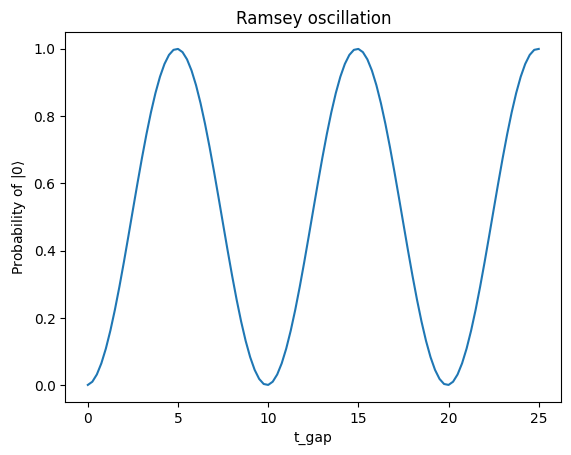

In [267]:
## the standard Ramsey interference experiment

psi0 = array([1,0], complex) # population starts in |0>

d = 2*pi/10 # delta. the energy shift between the states
o = 2*pi # the rabi frequency

# atom+field Hamiltonian, hbar=1
Haf = lambda t: array([[0,-o*exp(1j*d*t)/2],[-o*exp(-1j*d*t)/2,0]])

numsteps = 25
tmin = 0
tmax = pi/(2*o)

dpsi = lambda t,state: -1j*dot(Haf(t),state)

# apply the first pi/2 pulse
soln = solve_ivp(dpsi,[tmin,tmax],psi0,vectorized=True)
psi0 = array([1,0], complex) 
soln = solve_ivp(dpsi,[0,pi/(2*o)],psi0,vectorized=True)
psi0 = array([soln.y[0,-1], soln.y[1,-1]],complex) # population in superposition of ms=0 and ms=1

# the state after evolving a time t along the equator
psi = lambda t: array([psi0[0], psi0[1]*exp(1j*d*t)])

numsteps = 25
tmin = 0
tmax =  pi/(2*o) # pi/2 time

tgaps = linspace(0,5*pi/abs(d),101)
p0 = zeros(len(tgaps))
p1 = zeros(len(tgaps))
for i,tgap in enumerate(tgaps): # let the state evolve on the equator for differnt gap times
    
    psi_equator = psi(tgap)
    
    # apply the second pi/2 pulse to the state after it has evolved on the equator for tgap
    soln = solve_ivp(dpsi,[tmin,tmax],psi_equator,vectorized=True)
    p0[i] = abs(soln.y[0,-1])**2
    p1[i] = abs(soln.y[1,-1])**2
plt.plot(tgaps,p0)
plt.title("Ramsey oscillation")
plt.xlabel("t_gap")
plt.ylabel(r"Probability of $|0\rangle$")
plt.show()

### Random $\Delta$
Sample $\Delta$ from a normal distribution

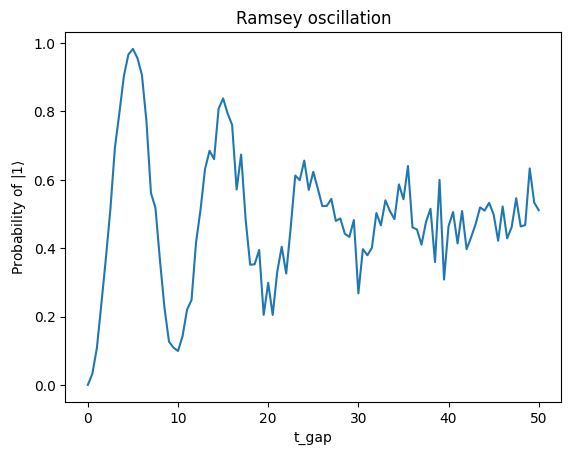

In [303]:
## Ramsey experiment where we average over runs with different delta 

psi0 = array([1,0], complex) # population starts in |0>

d_mean = 2*pi/10
d_std = 2*pi/100

d = lambda t: normal(loc=d_mean, scale=d_std) # delta. for each time t, delta will be picked from a normal dist.
o = 2*pi # the rabi frequency

# atom+field Hamiltonian, hbar=1
Haf = lambda t: array([[0,-o*exp(1j*d_mean*t)/2],[-o*exp(-1j*d_mean*t)/2,0]])

tmin = 0
tmax = pi/(2*o)

dpsi = lambda t,state: -1j*dot(Haf(t),state)

# apply the first pi/2 pulse
soln = solve_ivp(dpsi,[tmin,tmax],psi0,vectorized=True)
psi0 = array([1,0], complex) 
soln = solve_ivp(dpsi,[0,pi/(2*o)],psi0,vectorized=True)
psi0 = array([soln.y[0,-1], soln.y[1,-1]],complex) # population in superposition of ms=0 and ms=1

# average over many runs, where each run will have a different delta during the gap time

runs = 30
avg = zeros(len(tgaps))

for j in range(runs):
    
    # the state after evolving a time t along the equator
    psi = lambda t: array([psi0[0], psi0[1]*exp(1j*d(t)*t)])

    tgaps = linspace(0,10*pi/abs(d_mean),101) # the gap times
    p0 = zeros(len(tgaps))
    for i,tgap in enumerate(tgaps): # let the state evolve on the equator for differnt gap times

        psi_equator = psi(tgap)

        # apply the second pi/2 pulse to the state after it has evolved on the equator for tgap
        soln = solve_ivp(dpsi,[tmin,tmax],psi_equator,vectorized=True)
        p0[i] = abs(soln.y[0,-1])**2
        
    avg += p0
avg /= runs 
plt.plot(tgaps, avg)
plt.title("Ramsey oscillation")
plt.xlabel("t_gap")
plt.ylabel(r"Probability of $|1\rangle$")
plt.show()

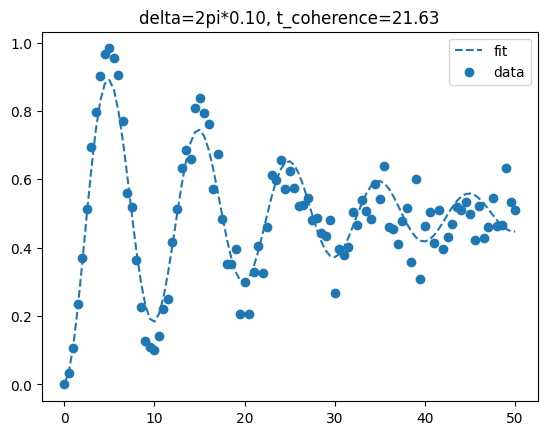

In [304]:
model = lambda t, delta, t_coherence, A: A - A*exp(-t/t_coherence)*cos(delta*t)
delta_guess = d_mean/2
t_coherence_guess = 20
A_guess = 0.5
popt, pcov = curve_fit(model,tgaps,avg,p0=[delta_guess,t_coherence_guess,A_guess])

delta,t_coherence,A = popt

fig,ax = plt.subplots()
ax.plot(tgaps,model(tgaps,*popt),linestyle='--',label='fit')
ax.scatter(tgaps,avg,label='data')
plt.legend()
ax.set_title(f"delta=2pi*{delta/(2*pi):.2f}, t_coherence={t_coherence:.2f}")
plt.show()